### Kinouchi \& Copelli Model

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
@partial(jax.vmap, in_axes=(None, None, None, None, 0, None))
def KC_model(
    A: jnp.ndarray, n_states: int, p: int, T: int, sigma: jnp.ndarray, seed: int
):
    # Set key for random
    key = jax.random.key(seed)

    # Number of nodes
    N = len(A)
    # Average degree
    K = A.sum(1).mean()
    # Maximal probability
    pmax = 2 * sigma / K
    # Assign weights
    W = A * jax.random.uniform(key, shape=(N, N))
    W = pmax * (W + W.T) / 2
    # Times
    times = jnp.arange(T, dtype=jnp.int16)

    def _evolve(carry, t):
        # Get current states
        states = carry

        ####################################################################
        # Quiet cells may be activated and update cells
        ####################################################################
        Q = states == 0
        R = states >= 1
        # Check if any quiescent goes active
        dice_A = jax.random.uniform(jax.random.key(seed + t), shape=(N,)) < p

        ####################################################################
        # Excited cells may update neighbors
        ####################################################################
        E = states == 1

        dice_B = (
            jax.random.uniform(jax.random.key(seed + t + 1), shape=(N, N)) < E * W
        ).any(axis=1)

        new_states = (
            jnp.logical_and(Q, dice_A)
            + jnp.logical_and(Q, dice_B)
            + ((states + 1) % n_states) * R
        ).astype(jnp.int32)

        return new_states, states

    initial_carry = jax.random.randint(key, (N,), 0, n_states)
    _, states = jax.lax.scan(_evolve, initial_carry, times)

    return states.T

In [3]:
A = jax.random.uniform(jax.random.key(455454), shape=(5000, 5000))
A = (A + A.T) / 2
A = A >= 0.967
A = jnp.fill_diagonal(A, 0, inplace=False)

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [4]:
A.sum(0).mean()

Array(10.7987995, dtype=float32)

In [5]:
sigmas = jnp.linspace(0.01, 5, 50)

In [6]:
out = KC_model(A, 5, 0, 1000, sigmas, 10)

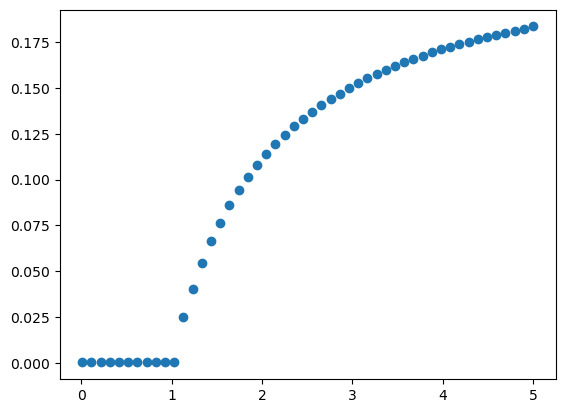

In [7]:
plt.plot(sigmas, (out == 1).mean((1, 2)), "o")

In [8]:
out.shape

(50, 5000, 1000)

In [9]:
import ripser

In [10]:
ph = ripser.ripser(out[0], maxdim=1)

In [18]:
ph['dgms'][0]

array([[0.        , 4.        ],
       [0.        , 4.12310553],
       [0.        , 4.2426405 ],
       [0.        , 4.35889912],
       [0.        ,        inf]])

In [15]:
ph['cocycles']

[[], []]